<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI/blob/master/1_Analysis/7_%EC%8B%9C%EA%B3%84%EC%97%B4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 시계열 데이터 분석
- 과거에서부터 이어져오는 데이터를 통해 패턴을 알아내고, 이것을 이용해 미래를 예측하는 분석 방법
- 시간 t를 기준으로 데이터가 측정되어 있음
- 예
  - 주식데이터, 환율, IOT센서 데이터, 공장 내 제조 등
  - 방법
    - 통계적으로는 기초 분석만
    - 상용화 제품을 이용한 예측모델 구축
      - facebook의 prophet
      - 위 제품을 직접 만든 모델과 성능 비교 차원으로 활용
    - 딥러닝의 RNN-LSTM을 예측모델 구축


In [2]:
# 설치
# 페이스북 prophet 설치 : 코랩에서 설치가 가장 쉬움, 윈도우는 잘 설치 안 됨(되긴 한데 복잡)
# !conda install -c conda-forge fbprophet
!pip install fbprophet

In [3]:
# 모듈 가져오기

import warnings
# 경고 무시 처리
warnings.filterwarnings('ignore')

# 기본
import numpy as np
import pandas as pd

# 예측용
from fbprophet import Prophet
# 시간 처리
from datetime import datetime

In [4]:
# 야후 파이낸스 설치
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 5.5MB 5.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=aea19cc74f65159dc2425b038b5cab0f56020a3230232a7288274163b3b3b05b
  Stored in directory: /tmp/pip-ephem-wheel-cache-z2h__s2p/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
# 데이터 획득 -> 종목코드를 넣어서 주식 데이터를 획득
# 야후 파이낸스에서 획득, 국내 공공데이터
from pandas_datareader import data
import yfinance as yf
# 최신상태로 데이터를 재정의
yf.pdr_override()

In [ ]:
# 전체 종목코드를 획득하여 코로나 이후 주가를 분석해보면 상승폭이 각각 다를 것
# -> 산업군 재편현황이 예측될 듯

In [6]:
# 시작일, 종료일, 주식코드
start_date = '2010-01-01'
end_date   = '2020-07-20'
# 미국
TRADE_CODE = 'AMD'

data.get_data_yahoo( TRADE_CODE, start_date, end_date )

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,9.790000,9.900000,9.680000,9.700000,9.700000,18748700
2010-01-05,9.710000,9.900000,9.680000,9.710000,9.710000,22145700
2010-01-06,9.680000,9.760000,9.550000,9.570000,9.570000,18643400
2010-01-07,9.510000,9.550000,9.180000,9.470000,9.470000,26806800
2010-01-08,9.370000,9.470000,9.290000,9.430000,9.430000,13752800
...,...,...,...,...,...,...
2020-07-13,56.680000,58.349998,53.380001,53.590000,53.590000,57741800
2020-07-14,53.299999,54.860001,52.259998,54.720001,54.720001,54890100
2020-07-15,54.959999,55.369999,53.590000,55.340000,55.340000,42360300


[*********************100%***********************]  1 of 1 completed


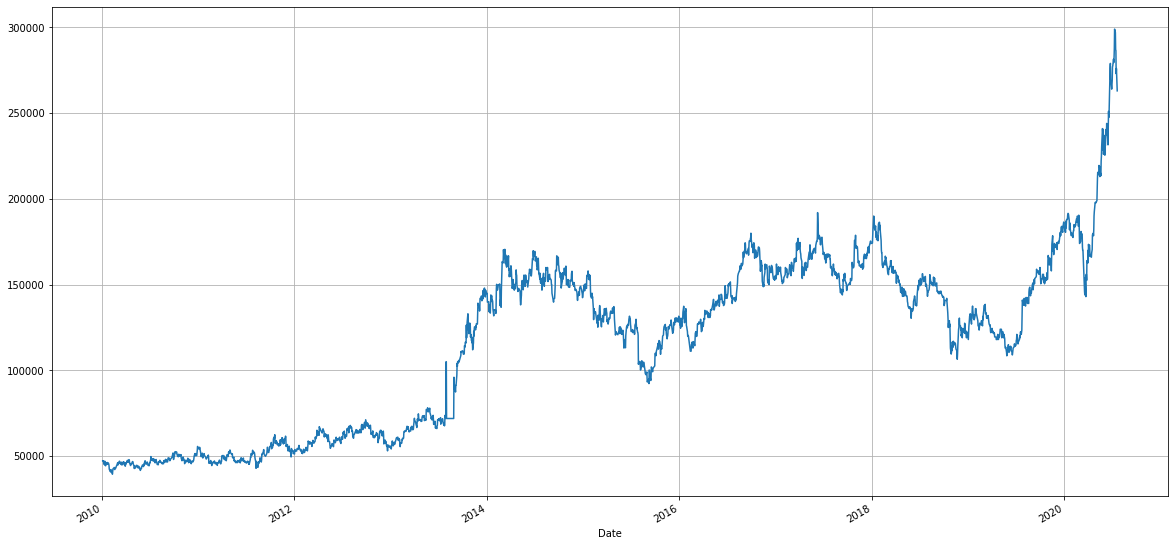

In [7]:
# 국내 증시 데이터는 야후 입장에서 보면 외국 데이터이므로 임시공휴일, 선거일로 인한 공휴일 등 모른 -> 결측치 존재
# 종가 기준으로 시각화
TRDADE_CODE= '035420.KS' 
naver_df   = data.get_data_yahoo( TRDADE_CODE, start_date, end_date )

naver_df['Close'].plot(figsize = (20,10), grid = True)

In [8]:
# 2020-07-20에서 365일 이전까지 데이터
naver_df_trunc = naver_df[:"2019-07-20"]
naver_df_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,46577.398438,47435.398438,46332.300781,47312.800781,44615.210938,974308
2010-01-05,46945.101562,48048.300781,46577.398438,47312.800781,44615.210938,920401
2010-01-06,47312.800781,48293.398438,47067.699219,47067.699219,44384.082031,1283697
2010-01-07,47190.300781,48048.300781,46822.601562,47190.300781,44499.687500,733984
2010-01-08,47190.300781,47803.101562,45596.800781,45596.800781,42997.046875,885303
...,...,...,...,...,...,...
2019-07-15,118000.000000,120000.000000,116500.000000,118000.000000,118000.000000,263893
2019-07-16,119000.000000,120500.000000,117500.000000,120000.000000,120000.000000,391260
2019-07-17,120000.000000,120000.000000,118000.000000,119000.000000,119000.000000,205316


[*********************100%***********************]  1 of 1 completed


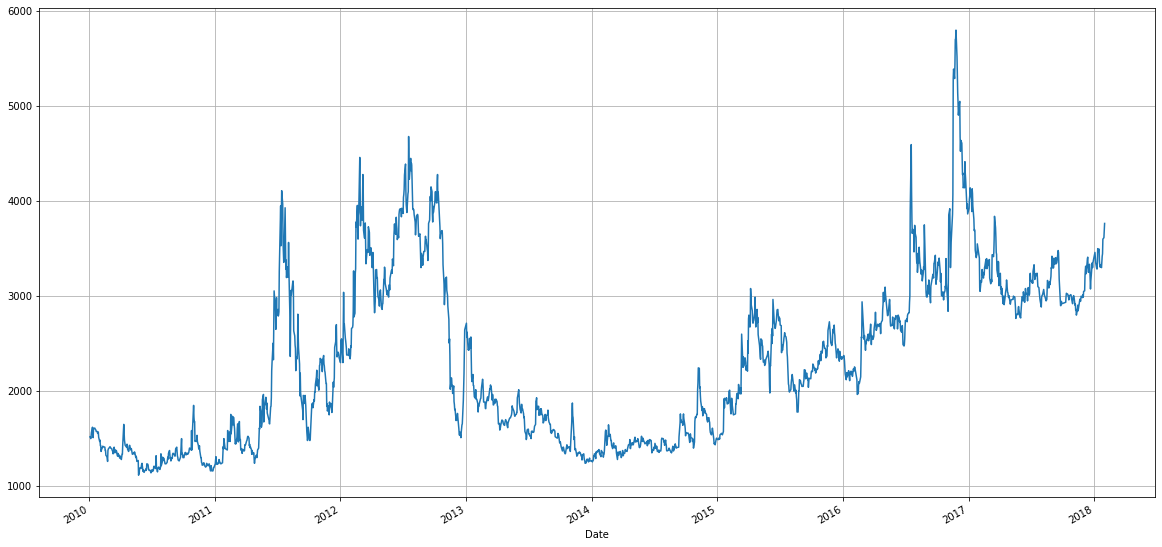

In [9]:
# 토탈소프트
ts_df   = data.get_data_yahoo( '045340.KQ', start_date, end_date )

ts_df['Close'].plot(figsize = (20,10), grid = True)

In [10]:
# 분석 -> 평균이동선(5ma, 20ma, 60ma, 120ma) 등을 시각화
# 평균이동선 -> 데드 크로스, 골든 크로스 시점을 예측 -> 상승각, 하락각인지 예측

In [11]:
# prophet을 이용해 시즌 분석, 계절 분석 등 시간 관점에서 분석
# prophet : https://facebook.github.io/prophet/docs/quick_start.html
# 언제 매수/매도할지, 근 1주일 ~ 가까운 미래까지 주가 예측 可 -> 참고용

# 데이터를 맞는 형태로 구성
# 데이터는 ds에 시간을, y에는 수치 데이터(예측하고자 하는)를 입력하는 df를 구성
dic = {
    'ds' : naver_df_trunc.index,
    'y'  : naver_df_trunc['Close']
}
df = pd.DataFrame(dic)
df.reset_index(inplace=True, drop=True)
# df.drop('Date', axis = 1, inplace=True)
# del df['Date']
df

,ds,y
0,2010-01-04,47312.800781
1,2010-01-05,47312.800781
2,2010-01-06,47067.699219
3,2010-01-07,47190.300781
4,2010-01-08,45596.800781
...,...,...
2346,2019-07-15,118000.000000
2347,2019-07-16,120000.000000
2348,2019-07-17,119000.000000
2349,2019-07-18,120500.000000


In [12]:
# 예측 모델 생성 -> 2010-01-04 ~ 2019-07-19
# 주기성을 일 단위로 설정
model = Prophet( daily_seasonality=True ) 
# 학습
model.fit( df )

In [13]:
# 예측하는 기간을 설정
# 2010-01-04 ~ 훈련기간 + 예측해야할 기간 : 365+2 -> fu_df 구성
# 실제 예측할 기간만 부여하면 알아서 훈련했던 기간부터 적용하여 데이터 없는 부분부터 추가된 기간까지 예측해서 데이터 생성
fu = model.make_future_dataframe( periods=365+2 )
fu.tail(3)

,ds
2715,2020-07-18
2716,2020-07-19
2717,2020-07-20


In [14]:
# 예측
forecast = model.predict( fu )
# 예측에 대한 항목 설정
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,46198.853160,37241.455798,55075.330831,46198.853160,46198.853160,-20.162492,-20.162492,-20.162492,-2245.051337,-2245.051337,-2245.051337,-178.161409,-178.161409,-178.161409,2403.050254,2403.050254,2403.050254,0.0,0.0,0.0,46178.690668
1,2010-01-05,46211.552309,36981.504872,55849.399777,46211.552309,46211.552309,468.783289,468.783289,468.783289,-2245.051337,-2245.051337,-2245.051337,73.789310,73.789310,73.789310,2640.045316,2640.045316,2640.045316,0.0,0.0,0.0,46680.335598


In [15]:
forecast.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2716,2020-07-19,89026.097047,57318.371279,116472.739026,60978.462933,119939.368138,-2671.622122,-2671.622122,-2671.622122,-2245.051337,-2245.051337,-2245.051337,280.631491,280.631491,280.631491,-707.202276,-707.202276,-707.202276,0.0,0.0,0.0,86354.474925
2717,2020-07-20,88948.855450,56247.476819,115921.967255,60753.285704,119918.940204,-3346.896229,-3346.896229,-3346.896229,-2245.051337,-2245.051337,-2245.051337,-178.161409,-178.161409,-178.161409,-923.683483,-923.683483,-923.683483,0.0,0.0,0.0,85601.959222


In [16]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [17]:
# 예측에 대한 항목 설정
# ds 
# yhat_lower : 예측의 불확실성을 표현하는 값의 간격의 최소값
# yhat_upper : 예측의 불확실성을 표현하는 값의 간격의 최대값
# yhat 
forecast[ [ 'ds', 'yhat_lower', 'yhat_upper', 'yhat' ] ].head(2)

,ds,yhat_lower,yhat_upper,yhat
0,2010-01-04,37241.455798,55075.330831,46178.690668
1,2010-01-05,36981.504872,55849.399777,46680.335598


In [18]:
forecast[ [ 'ds', 'yhat_lower', 'yhat_upper', 'yhat' ] ].tail(2)

,ds,yhat_lower,yhat_upper,yhat
2716,2020-07-19,57318.371279,116472.739026,86354.474925
2717,2020-07-20,56247.476819,115921.967255,85601.959222


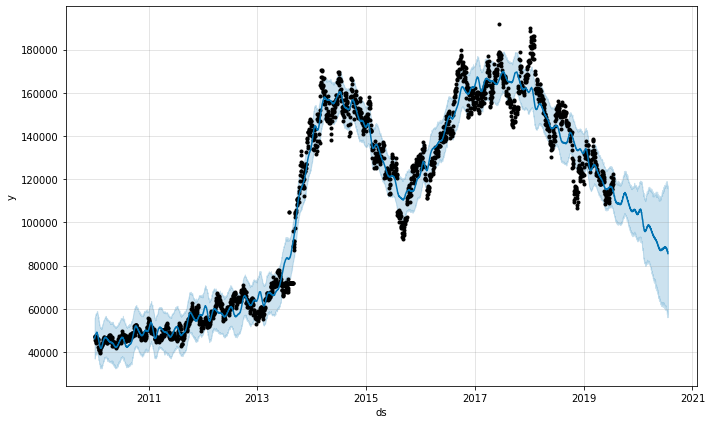

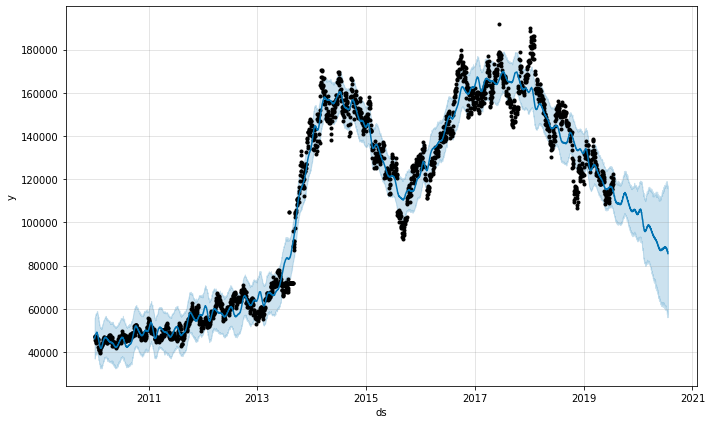

In [19]:
# 주가에 대한 선형 그래프, 예측구간 표현
model.plot( forecast )

# 원래 네이버는 하락세였는데, 코로나 이후로 비대면서비스 등 패러다임의 전환 발생 -> 3월장 이후로 상승하게 됨(실제)
# -> 주식데이터만으로는 분석할 수 없는 외부 요인 크게 작용함

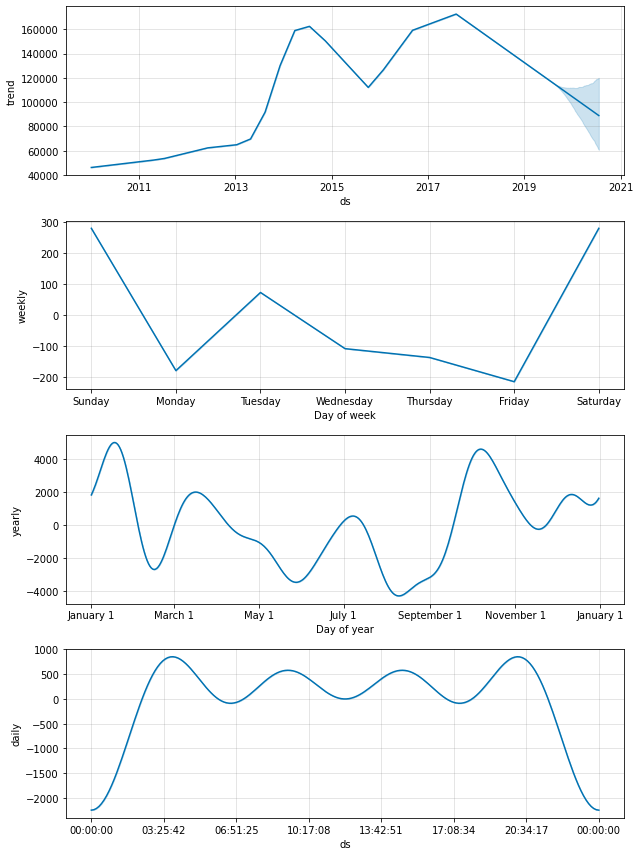

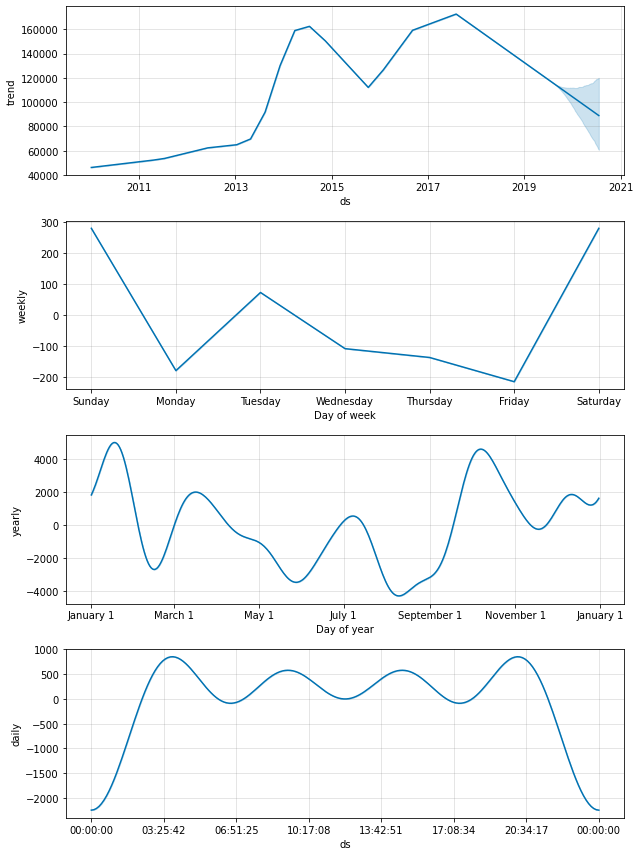

In [20]:
# 성분 분석
model.plot_components( forecast )

# 주식의 매수/매도 시기(주간 기준, 연간 기준)를 예측해줌
# 일단위에서 시간 당 예측은 데이터가 없었기 때문에 무시
# 주가와 시간만으로 분석한 데이터이므로, 회사 내 or 외부 요인에 대한 비중이 가미되어야 대략적인 예측이 가능할 것으로 보임

In [21]:
# 코로나 영향 확인
start_date = '2020-02-01'
end_date   = '2020-07-19'
TRADE_CODE = '035420.KS'

naver_df_corona  = data.get_data_yahoo( TRADE_CODE, start_date, end_date )

dic = {
    'ds' : naver_df_corona.index,
    'y'  : naver_df_corona['Close']
}
df2 = pd.DataFrame(dic)
df2.reset_index(inplace=True, drop=True)

model = Prophet( daily_seasonality=True ) 
model.fit( df2 )

fu2 = model.make_future_dataframe( periods=7 )
forecast2 = model.predict( fu2 )
forecast2[ [ 'ds', 'yhat_lower', 'yhat_upper', 'yhat' ] ]

[*********************100%***********************]  1 of 1 completed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat_lower,yhat_upper,yhat
0,2020-02-03,177472.565027,197395.134487,188005.032103
1,2020-02-04,178470.974370,198198.162271,188006.406340
2,2020-02-05,178217.960635,198061.809454,187845.199119
3,2020-02-06,177578.538114,196735.765420,187308.804193
4,2020-02-07,176980.346262,196551.667682,187240.902510
...,...,...,...,...
118,2020-07-20,284047.678085,302854.817197,293509.775174
119,2020-07-21,284946.109334,304641.187437,295103.529942
120,2020-07-22,286777.810971,306497.190054,296534.703251
121,2020-07-23,287451.757060,307367.558426,297590.688856


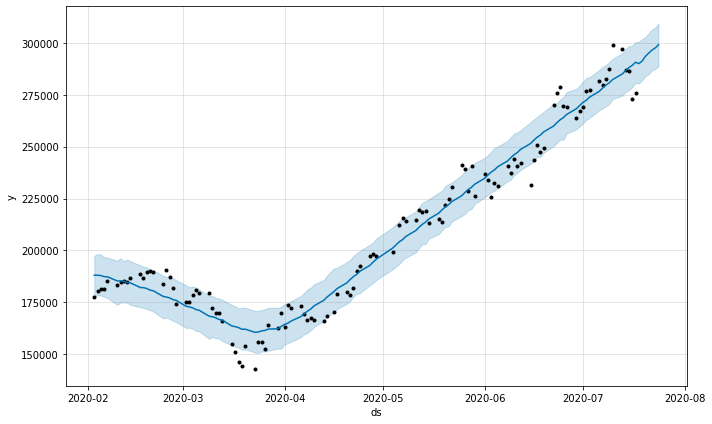

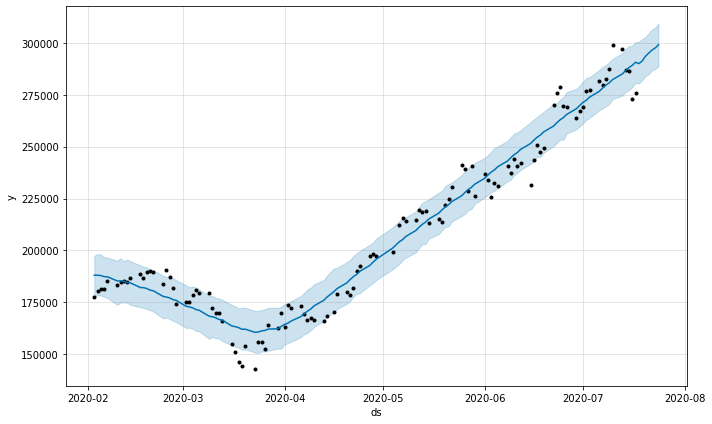

In [22]:
model.plot( forecast2 )

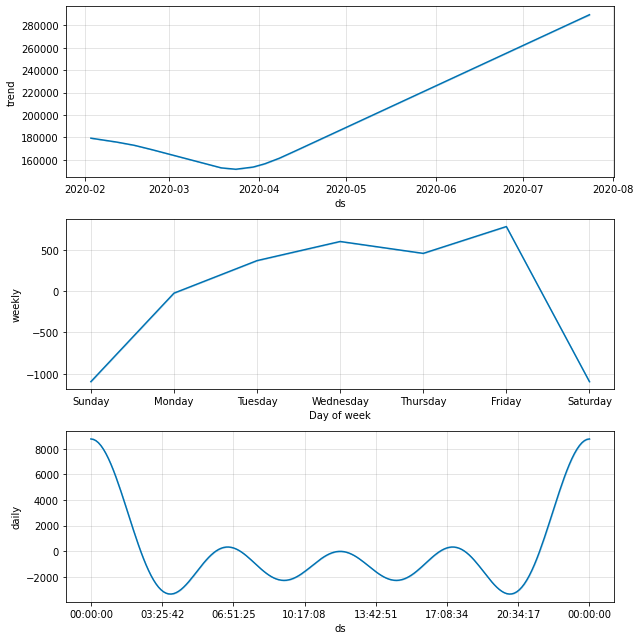

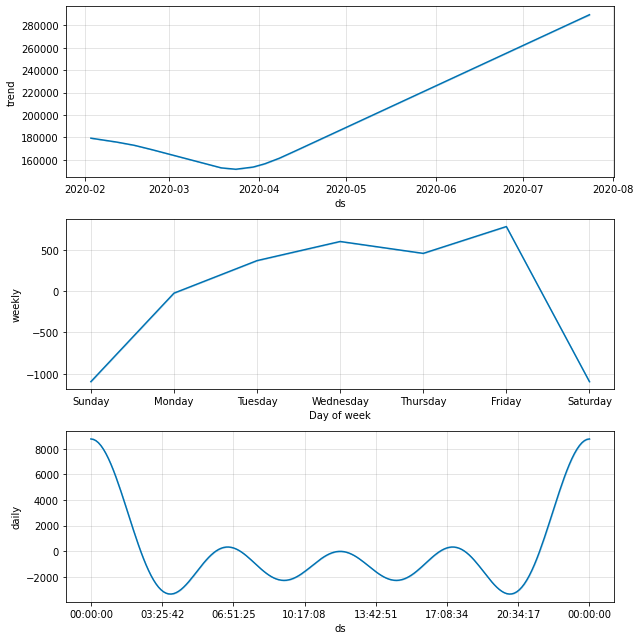

In [23]:
model.plot_components( forecast2 )

# 주식 데이터 로드 및 처리
- 1개 이상

In [24]:
start_date = '2010-01-01'
end_date   = '2020-07-20'
# 관심목록을 리스트로 구성해서 한번에 로드
stock_df = data.get_data_yahoo( ['035420.KS', 'NVDA'], start_date, end_date )
stock_df.head(3)

[*********************100%***********************]  2 of 2 completed


Adj Close                    Close  ...   Open     Volume            
               035420.KS       NVDA     035420.KS  ...   NVDA  035420.KS        NVDA
Date                                               ...                              
2010-01-04  44615.210938  17.004965  47312.800781  ...  18.51   974308.0  20005100.0
2010-01-05  44615.210938  17.253283  47312.800781  ...  18.42   920401.0  18216200.0
2010-01-06  44384.082031  17.363640  47067.699219  ...  18.75  1283697.0  16229200.0

[3 rows x 12 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0481ff5358>,
      dtype=object)

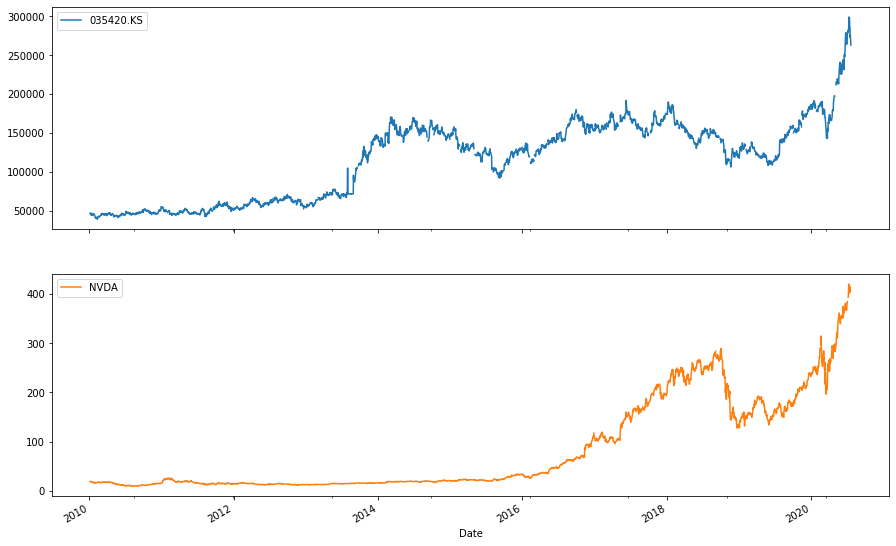

In [25]:
# 시각화
stock_df['Close'].plot( figsize=(15,10), subplots=True )

In [26]:
import matplotlib.pyplot as plt

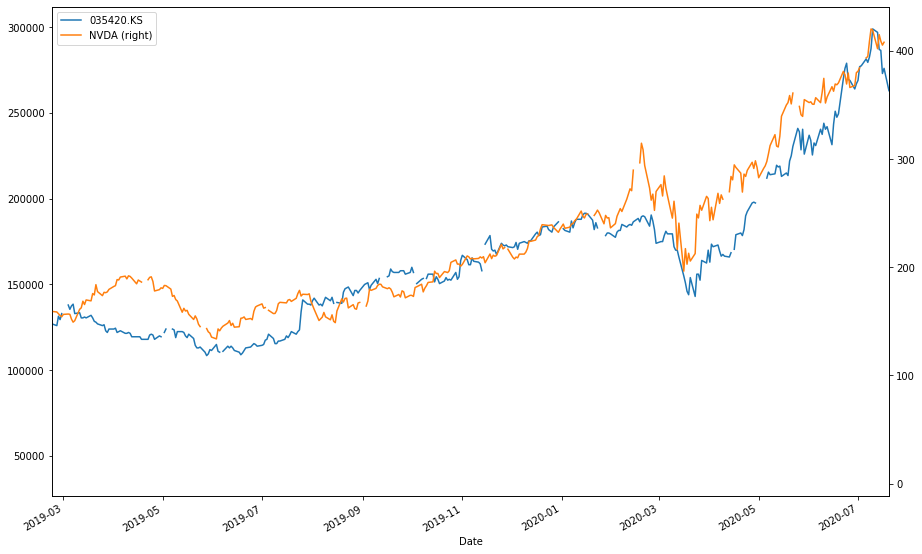

In [27]:
# 1개의 차트로 표현
# 제일 좋은 부분은 화폐단위 맞춰서 그려보면 직접 비교 可
# 화폐 단위가 달라도 주가의 흐름은 비교 可
# 특정 주가가 특정 주가의 영향을 미치는가
stock_df['Close'].plot( figsize=(15,10), secondary_y='NVDA' )

# 코로나 시기 이후로 주가 움직임이 유사해짐 -> 코로나 이후로 차트를 제한해서 확인
plt.xlim(stock_df.index[-365],stock_df.index[-1])
plt.show()

# 코로나 이후로 추세는 유사하게 작동

# 평균 이동선
- 주가 분석의 기초사항
- 'Adj Close'(조정 종가)를 이용해 5일 단위, 20일, 60일, 120일 단위로 이동평균선을 예상하여 실 차트 위에 그리기 可
- 상승장인지 하락장인지를 예측하는 지표
- 골든 크로스
  - 단기GC : 5일 이동평균선이 20일 이동평균선을 상향 돌파했을 때 감지 -> 단타 쪽에서 상승장으로 확인
  - 중기GC : 20 -> 60, 강세장 시작
  - 장기GC5 : 60 ->120, 일반적으로 사용되는 지표
- 데드 크로스
  - 약세장 신호
  - 골든크로스의 반대 상황
- 코인 데이터 : https://coinone.co.kr/chart?site=coinone&unit_time=15m

In [28]:
import pandas as pd
import pandas_datareader.data as yh
import matplotlib.pyplot as plt

start_date = '2010-01-01'
end_date   = '2020-07-20'
stock_df   = data.get_data_yahoo( '035420.KS', start_date, end_date )

[*********************100%***********************]  1 of 1 completed


In [29]:
# 이동평균선 계산시, Volume값이 0인 부분은 제외
stock_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [30]:
stock_df2 = stock_df[stock_df['Volume'] != 0]
stock_df2.shape

(2569, 6)

In [31]:
# 5ma, 20ma, 60ma, 120ma
# 5ma -> 5일치 데이터가 모여야지 계산이 가능
# 5일째가 되면 합산해서 평균계산하여 값을 획득
# 6일째가 되면 2일차~6일차까지 합산및 평균계산해서 값을 획득
ma5   = stock_df2['Adj Close'].rolling(window=5).mean()
ma20  = stock_df2['Adj Close'].rolling(window=20).mean()
ma60  = stock_df2['Adj Close'].rolling(window=60).mean()
ma120 = stock_df2['Adj Close'].rolling(window=120).mean()

# 데이터는 가급한 한국에서 받으면 정확하다.
# 현재 실제 283,900
ma5[-1]

277100.0

In [32]:
# stock_df2에 파생변수로 추가 : 컬럼명 : ma5 ~ ma120
stock_df2[ 'ma5' ] = ma5
# api로 추가
stock_df2.insert( len(stock_df2.columns), 'ma20', ma20 )

In [33]:
stock_df2[ 'ma60' ] = ma60
stock_df2[ 'ma120' ] = ma120

In [34]:
stock_df2.head(10)

,Open,High,Low,Close,Adj Close,Volume,ma5,ma20,ma60,ma120
Date,,,,,,,,,,
2010-01-04,46577.398438,47435.398438,46332.300781,47312.800781,44615.210938,974308,NaN,NaN,NaN,NaN
2010-01-05,46945.101562,48048.300781,46577.398438,47312.800781,44615.210938,920401,NaN,NaN,NaN,NaN
2010-01-06,47312.800781,48293.398438,47067.699219,47067.699219,44384.082031,1283697,NaN,NaN,NaN,NaN
2010-01-07,47190.300781,48048.300781,46822.601562,47190.300781,44499.687500,733984,NaN,NaN,NaN,NaN
2010-01-08,47190.300781,47803.101562,45596.800781,45596.800781,42997.046875,885303,44222.247656,NaN,NaN,NaN
2010-01-11,45351.699219,46209.699219,44371.101562,44984.000000,42419.187500,1501720,43783.042969,NaN,NaN,NaN
2010-01-12,45596.800781,47067.699219,45351.699219,47067.699219,44384.082031,1407326,43736.817187,NaN,NaN,NaN
2010-01-13,46454.800781,47067.699219,45106.601562,45842.000000,43228.269531,861627,43505.654687,NaN,NaN,NaN
2010-01-14,45474.300781,46087.101562,44738.800781,44738.800781,42187.964844,1288674,43043.310156,NaN,NaN,NaN


In [35]:
stock_df2.tail()

,Open,High,Low,Close,Adj Close,Volume,ma5,ma20,ma60,ma120
Date,,,,,,,,,,
2020-07-14,290000.0,291000.0,285000.0,287000.0,287000.0,1360849,290600.0,274000.0,237008.333333,205558.333333
2020-07-15,290500.0,293000.0,280500.0,286500.0,286500.0,1276196,291400.0,275775.0,238800.000000,206354.166667
2020-07-16,283000.0,285000.0,272000.0,273000.0,273000.0,1338814,288500.0,277050.0,240350.000000,207066.666667
2020-07-17,270000.0,279500.0,266000.0,276000.0,276000.0,926932,283900.0,278375.0,241975.000000,207850.000000
2020-07-20,276500.0,278000.0,260500.0,263000.0,263000.0,1556415,277100.0,278025.0,243325.000000,208491.666667


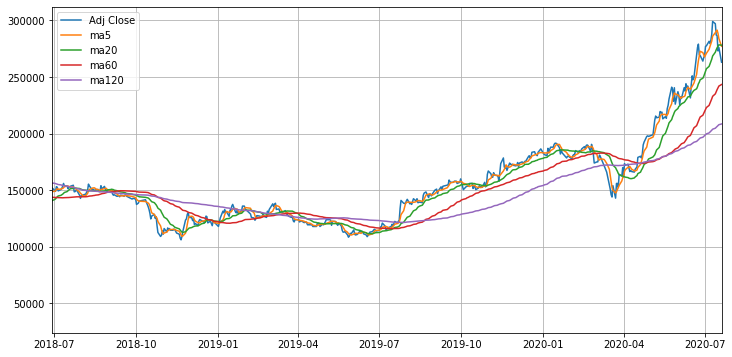

In [36]:
# 시각화
plt.figure( figsize=(12,6) )

# 플로팅
# x: 날짜, y:주가
plt.plot( stock_df2.index, stock_df2['Adj Close'], label='Adj Close' )
plt.plot( stock_df2.index, stock_df2['ma5'], label='ma5' )
plt.plot( stock_df2.index, stock_df2['ma20'], label='ma20' )
plt.plot( stock_df2.index, stock_df2['ma60'], label='ma60' )
plt.plot( stock_df2.index, stock_df2['ma120'], label='ma120' )

# 범례
plt.legend()
plt.grid()
# x출 날짜를 어제부터 500일가지로 제한
plt.xlim( stock_df2.index[-500], stock_df2.index[-1] )
plt.show()

# 데이터 특성상 인터랙티브한 차트로 드로잉하는 것이 더 적절해보임